## README
- This notebook presents a structured analysis for unsupervised topic discovery using the 20 Newsgroups dataset. 
- Data:   https://www.kaggle.com/datasets/crawford/20-newsgroups
- GitHub: https://github.com/wuwa58/20_Newsgroups

## 1. Introduction
Objective: Discover latent topics in the 20 Newsgroups corpus using LDA and K‑means, compare methods, and evaluate their strengths and limitations.

Outline:
1. Data Loading & Provenance
2. Exploratory Data Analysis (EDA)
3. Feature Extraction
4. LDA Topic Modeling
5. K‑means Clustering
6. Results & Discussion
7. Conclusion

## 2. Data Loading & Provenance

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

newsgroups = fetch_20newsgroups(
    subset='all',
    remove=('headers','footers','quotes'),
    shuffle=True,
    random_state=42
)

df = pd.DataFrame({
    'text': newsgroups.data,
    'label': newsgroups.target
})

df['topic'] = df['label'].apply(lambda i: newsgroups.target_names[i])

## 3. EDA
### 3.1 Document Count per Topic

                       topic  count
0           rec.sport.hockey    999
1     soc.religion.christian    997
2            rec.motorcycles    996
3         rec.sport.baseball    994
4                  sci.crypt    991
5                  rec.autos    990
6                    sci.med    990
7             comp.windows.x    988
8                  sci.space    987
9    comp.os.ms-windows.misc    985
10           sci.electronics    984
11  comp.sys.ibm.pc.hardware    982
12              misc.forsale    975
13             comp.graphics    973
14     comp.sys.mac.hardware    963
15     talk.politics.mideast    940
16        talk.politics.guns    910
17               alt.atheism    799
18        talk.politics.misc    775
19        talk.religion.misc    628


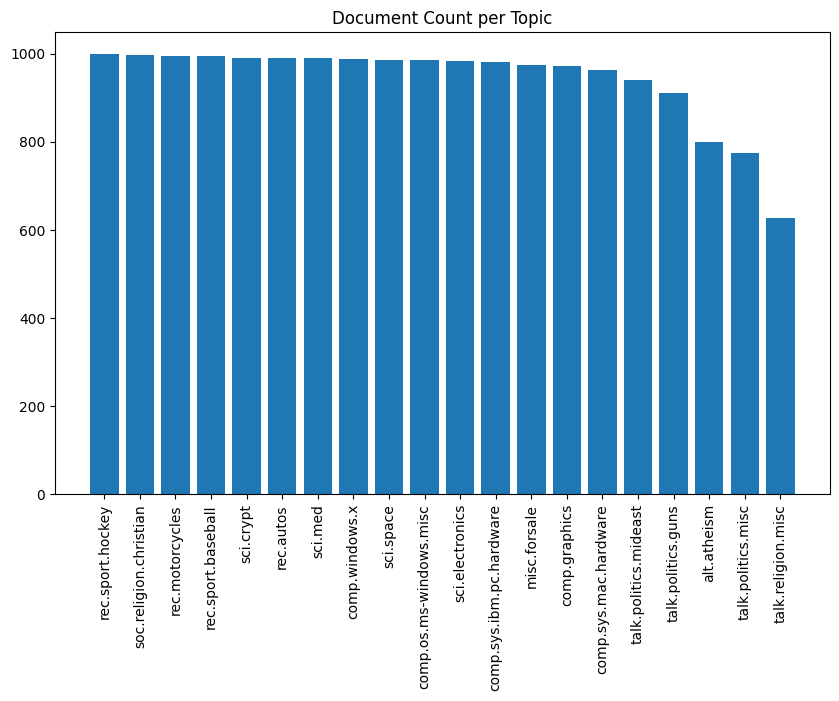

In [2]:
counts = df['topic'].value_counts().reset_index()
counts.columns = ['topic','count']
print(counts)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(counts['topic'], counts['count'])
plt.xticks(rotation=90)
plt.title('Document Count per Topic')
plt.show()

### 3.2 Document Lengths

          char_count    word_count
count   18846.000000  18846.000000
mean     1169.667516    181.637748
std      3858.748875    501.333800
min         0.000000      0.000000
25%       234.000000     40.000000
50%       489.000000     83.000000
75%       979.000000    166.000000
max    158791.000000  11765.000000


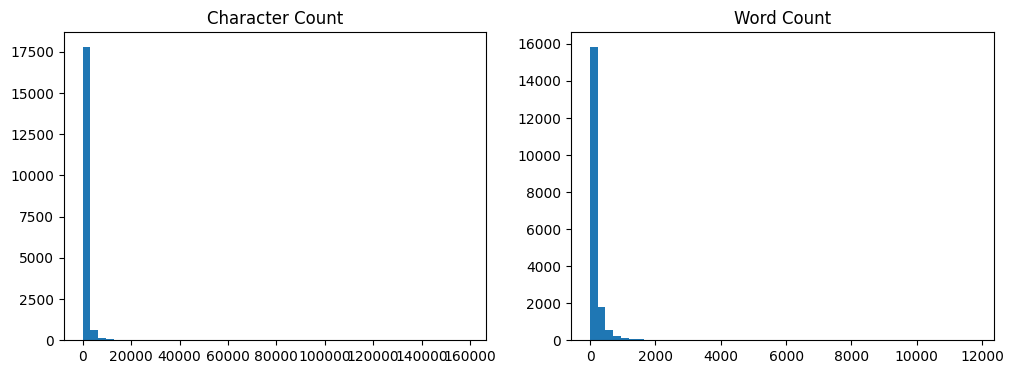

In [3]:
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].apply(lambda t: len(t.split()))
print(df[['char_count','word_count']].describe())
# Histograms
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(df['char_count'], bins=50)
axes[0].set_title('Character Count')
axes[1].hist(df['word_count'], bins=50)
axes[1].set_title('Word Count')
plt.show()

### 3.3 Filter Outlier Documents

In [4]:
df_clean = df[(df['word_count']>=10)&(df['word_count']<=1000)].copy()
print(f"Kept {len(df_clean)}/{len(df)} docs")

Kept 17388/18846 docs


## 4. Feature Extraction
### 4.1 Count Vectorizer for LDA

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(min_df=5, max_df=0.8, stop_words='english', ngram_range=(1,2))
X_counts = count_vec.fit_transform(df_clean['text'])
print('Count matrix shape:', X_counts.shape)

Count matrix shape: (17388, 33139)


### 4.2 TF-IDF for K‑means

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(min_df=5, max_df=0.8, stop_words='english', ngram_range=(1,2))
X_tfidf = tfidf_vec.fit_transform(df_clean['text'])
print('TF-IDF matrix shape:', X_tfidf.shape)

TF-IDF matrix shape: (17388, 33139)


## 5. LDA Topic Modeling

Topic 0: god, people, does, think, say, believe, jesus, don, know, just
Topic 1: game, team, space, games, year, play, hockey, season, gm, period
Topic 2: ax, ax ax, max, max ax, ax max, g9v, b8f, a86, g9v g9v, pl
Topic 3: 00, 10, 20, 15, sale, 17, 25, 11, 12, 1993
Topic 4: just, don, like, think, time, know, ve, good, people, way
Topic 5: drive, card, scsi, use, does, know, thanks, disk, mac, monitor
Topic 6: government, people, law, gun, state, fbi, public, right, police, guns
Topic 7: key, car, use, used, new, chip, like, power, keys, phone
Topic 8: windows, edu, file, use, program, thanks, com, like, know, mail
Topic 9: don, year, good, think, know, like, just, better, game, time


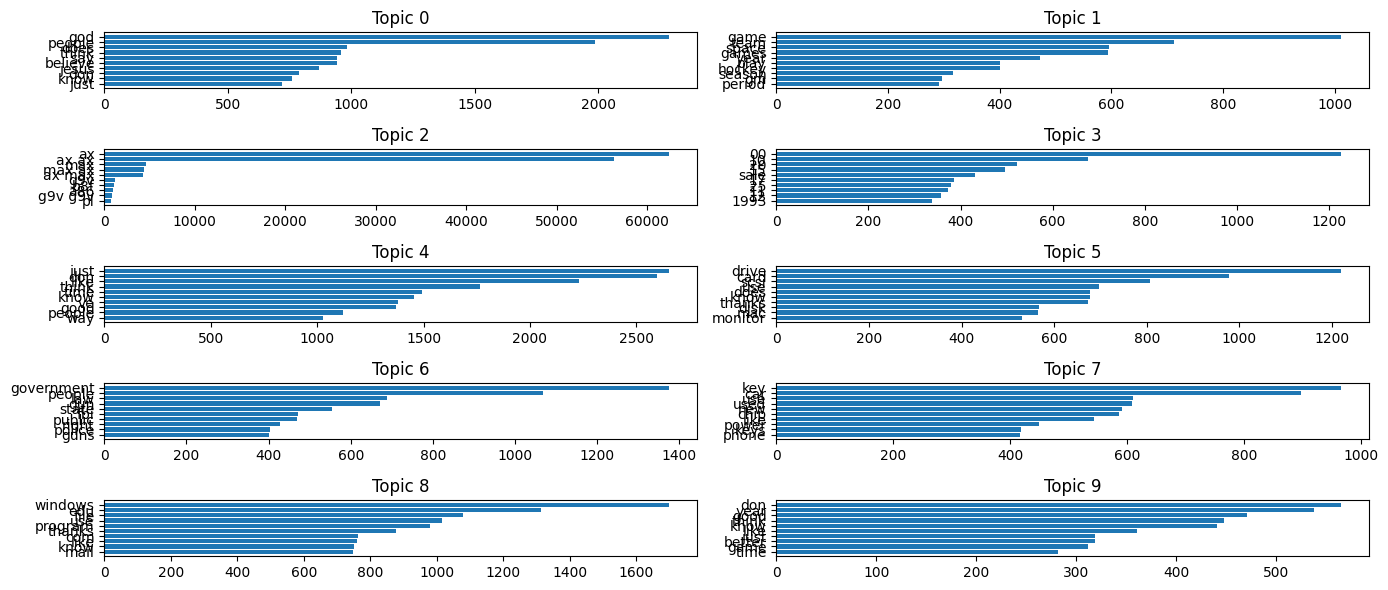

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
# Fit LDA
n_topics=10
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, learning_method='batch', random_state=42)
lda.fit(X_counts)

# Top-10 Terms per Topic
feature_names = count_vec.get_feature_names_out()
for i, comp in enumerate(lda.components_):
    terms = [feature_names[j] for j in comp.argsort()[-10:][::-1]]
    print(f"Topic {i}: {', '.join(terms)}")

# Visualization of Topics
import matplotlib.pyplot as plt
fig, axes = plt.subplots(n_topics//2,2,figsize=(14,n_topics*0.6))
axes=axes.flatten()
for i, ax in enumerate(axes):
    comp=lda.components_[i]
    top_idx=comp.argsort()[-10:][::-1]
    ax.barh([feature_names[j] for j in top_idx], comp[top_idx])
    ax.set_title(f"Topic {i}")
    ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 6. K‑means Clustering

Silhouette (k=10): 0.003460578723620787
Cluster 0: key, clipper, chip, encryption, keys, government, escrow, nsa, algorithm, clipper chip
Cluster 1: people, don, think, government, just, like, israel, right, say, did
Cluster 2: game, team, games, year, hockey, players, season, baseball, play, win
Cluster 3: car, bike, 00, sale, new, price, offer, condition, engine, shipping
Cluster 4: shameful surrender, surrender soon, intellect geb, edu shameful, dsl pitt, dsl, cadre dsl, geb cadre, n3jxp skepticism, banks n3jxp
Cluster 5: just, like, don, think, know, use, time, good, ve, does
Cluster 6: thanks, know, mail, does, advance, thanks advance, does know, hi, looking, help
Cluster 7: windows, file, window, program, dos, files, use, using, problem, running
Cluster 8: god, jesus, christ, believe, bible, faith, sin, christians, christian, people
Cluster 9: drive, scsi, card, disk, ide, bus, drives, controller, hard, hard drive


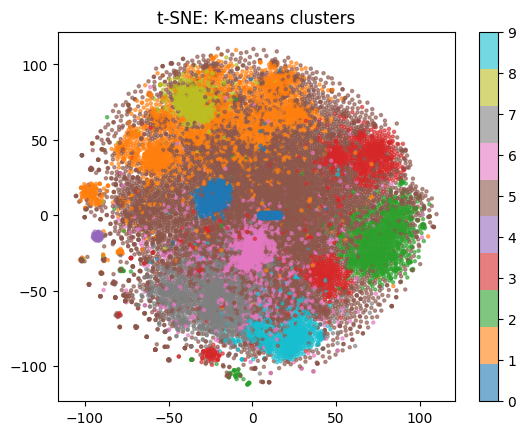

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Silhouette vs k
evals = []
for k in range(5,16):
    km=KMeans(n_clusters=k, random_state=42, n_init=10)
    labels=km.fit_predict(X_tfidf)
    evals.append(silhouette_score(X_tfidf, labels))
plt.plot(range(5,16), evals, marker='o'); plt.title('Silhouette Score vs k')

best_k=10
km=KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_km=km.fit_predict(X_tfidf)
print("Silhouette (k=10):", silhouette_score(X_tfidf, labels_km))
# Top-terms per cluster
terms=tfidf_vec.get_feature_names_out()
order=km.cluster_centers_.argsort()[:,::-1]
for i in range(best_k):
    print(f"Cluster {i}: {', '.join(terms[j] for j in order[i,:10])}")

from sklearn.manifold import TSNE
# random init directly on X_tfidf
tsne=TSNE(n_components=2, init='random', random_state=42, perplexity=50)
X2=tsne.fit_transform(X_tfidf)
plt.scatter(X2[:,0], X2[:,1], c=labels_km, cmap='tab10', s=5, alpha=0.6)
plt.title('t-SNE: K-means clusters'); plt.colorbar(); plt.show()

## 7. Results & Discussion

LDA Topics: Each topic’s top terms are semantically coherent (e.g., sports, hardware, politics). Soft assignments allow mixed-topic docs.

K-means Clusters: Hard segmentation recovers major themes but clumps generic chatter; cluster quality (silhouette ~0.0035) is lower.

Comparison: LDA better for nuanced topic mixtures; K-means faster but less flexible.